<a href="https://colab.research.google.com/github/Raoina/NLP-Learning-Journey/blob/main/Tasks/LSTM_stacked_layered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. choose a dataset
2. download and check the shape of the dataset
4. clean the data if needed (hint: regex)
5. decide the tokenization strategy (word , character , sub character)
6. build the vocab
7. build a wrapper around the dataset
8. dataloader -> train[0] (input,label)
9. Build network architecture
10. Training loop
11. evaluate


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# For loading datasets
from datasets import load_dataset

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Libraries imported successfully!


In [2]:
!pip install --upgrade datasets

In [3]:
from datasets import load_dataset

# Download the dataset
dataset = load_dataset("imdb")

# Get train and test data
train_data = dataset["train"]
test_data = dataset["test"]

# Display sample data
print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f"Sample review (text): {train_data[0]['text'][:100]}...")
print(f"Sample label (0=negative, 1=positive): {train_data[0]['label']}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset loaded! Total training examples: 25000
Sample review (text): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Sample label (0=negative, 1=positive): 0


In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
def preprocess_text(text):
    """Clean and tokenize the text"""
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

# Process training data
train_reviews = []
train_labels = []

for sample in tqdm(train_data):
    # Labels are already integers (0=negative, 1=positive)
    label_int = sample['label']
    train_labels.append(label_int)
    # Preprocess text
    tokens = preprocess_text(sample['text'])
    train_reviews.append(tokens)

# Process test data
test_reviews = []
test_labels = []

for sample in tqdm(test_data):
    label_int = sample['label']
    test_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    test_reviews.append(tokens)

print(f"Data preprocessing complete! Example tokenized review: {train_reviews[0][:15]}...")
print(f"Data preprocessing complete! Example tokenized label: {train_labels[0]}...")


100%|██████████| 25000/25000 [00:18<00:00, 1351.85it/s]

Data preprocessing complete! Example tokenized review: ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']...
Data preprocessing complete! Example tokenized label: 0...


In [6]:
def build_vocab(reviews, max_words=10000):
    """Build a vocabulary of the most common words"""
    word_count = Counter()

    # Count all words
    for review in reviews:
        word_count.update(review)

    # Select most common words
    most_common = word_count.most_common(max_words - 2)  # -2 for <UNK> and <PAD>
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}

    # Add special tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab

# Build vocabulary from training data
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)

print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(vocab.items())[:10]}")

# Create a reverse mapping for decoding
idx_to_word = {idx: word for word, idx in vocab.items()}


Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9), ('this', 10), ('i', 11)]


What should be the maximum length of my sequence aka review ??

Maximum review length: 2441
Mean review length: 227.81
Median review length: 170.0
95th percentile length: 583.0


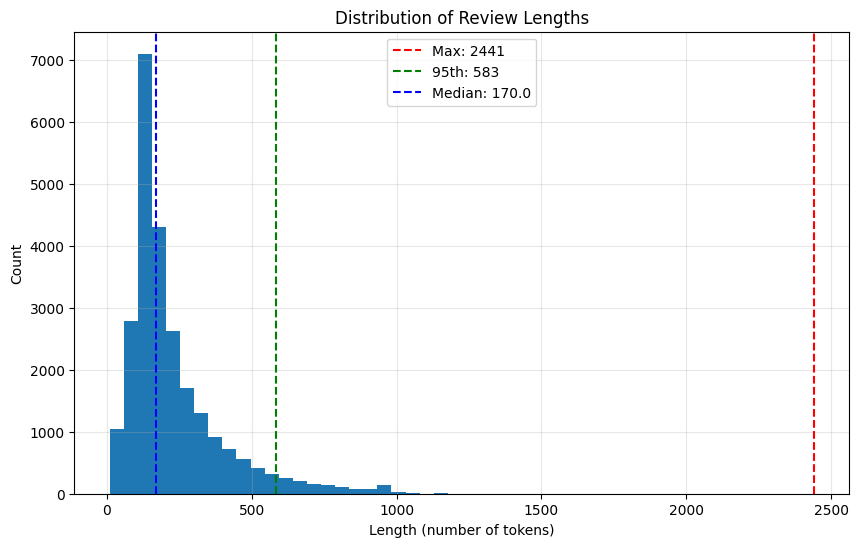

Chosen max_len: 583


100%|██████████| 25000/25000 [00:01<00:00, 18321.36it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...
All sequences are now of length 583
Reviews truncated: 1245 (4.98%)


In [7]:
# Analyze review lengths to determine optimal max_len
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)

print(f"Maximum review length: {max_review_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Choose max_len based on 95th percentile to avoid excessive padding
# while still covering most reviews without truncation
chosen_max_len = int(p95_length)
print(f"Chosen max_len: {chosen_max_len}")

def encode_review(review, vocab, max_len=None):
    """Convert a review to a fixed-length sequence of integers"""
    # Use the chosen max_len from analysis if none provided
    if max_len is None:
        max_len = chosen_max_len

    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

# Encode all reviews using the dynamically determined max_len
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

# Calculate how many reviews were truncated
truncated_count = sum(1 for length in review_lengths if length > chosen_max_len)
truncated_percentage = (truncated_count / len(review_lengths)) * 100
print(f"Reviews truncated: {truncated_count} ({truncated_percentage:.2f}%)")


In [8]:
def encode_review(review, vocab, max_len=200):
    """Convert a review to a fixed-length sequence of integers"""
    # Encode words, use <UNK> for unknown words
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

# Encode all reviews
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")


100%|██████████| 25000/25000 [00:01<00:00, 23448.41it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...


In [9]:
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create train/validation split
train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_sequences, train_labels_tensor, test_size=0.1, random_state=42
)

# Create datasets
train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"DataLoaders created! Training batches: {len(train_loader)}")


DataLoaders created! Training batches: 352


In [10]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim,
                        hidden_dim,
                        num_layers=n_layers,
                        bidirectional=False,
                        dropout=dropout if n_layers > 1 else 0,
                        batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text shape: [batch_size, seq_len]
        # Embed the text
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]

        # Pass through LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # hidden shape: [n_layers, batch_size, hidden_dim]

        # Use the final hidden state
        hidden = self.dropout(hidden[-1, :, :])  # [batch_size, hidden_dim]

        # Pass through linear layer
        return self.fc(hidden)  # [batch_size, output_dim]

# Initialize model
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2

model = SentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Model created and moved to {device}!")
print(model)

Model created and moved to cuda!
SentimentLSTM(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [11]:
# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


In [12]:
def train(model, iterator, optimizer, criterion):
    """Training function for one epoch"""
    # Set model to training mode
    model.train()

    # Track loss
    epoch_loss = 0
    epoch_acc = 0

    # Iterate over batches
    for batch in tqdm(iterator, desc="Training"):
        # Get batch data
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(text).squeeze(1)

        # Calculate loss
        loss = criterion(predictions, labels)

        # Calculate accuracy
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float()
        accuracy = correct.sum() / len(correct)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()

    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [13]:
def evaluate(model, iterator, criterion):
    """Evaluation function"""
    # Set model to evaluation mode
    model.eval()

    # Track loss
    epoch_loss = 0
    epoch_acc = 0

    # No gradients needed for evaluation
    with torch.no_grad():
        # Iterate over batches
        for batch in tqdm(iterator, desc="Evaluating"):
            # Get batch data
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            # Forward pass
            predictions = model(text).squeeze(1)

            # Calculate loss
            loss = criterion(predictions, labels)

            # Calculate accuracy
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float()
            accuracy = correct.sum() / len(correct)

            # Update metrics
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()

    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [14]:
n_epochs = 1

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("\nTraining complete!")


Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 50.19it/s]


Train Loss: 0.6933 | Train Acc: 50.82%
Val Loss: 0.6944 | Val Acc: 48.79%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 79.57it/s]


Train Loss: 0.6930 | Train Acc: 51.51%
Val Loss: 0.6807 | Val Acc: 58.32%

Training complete!


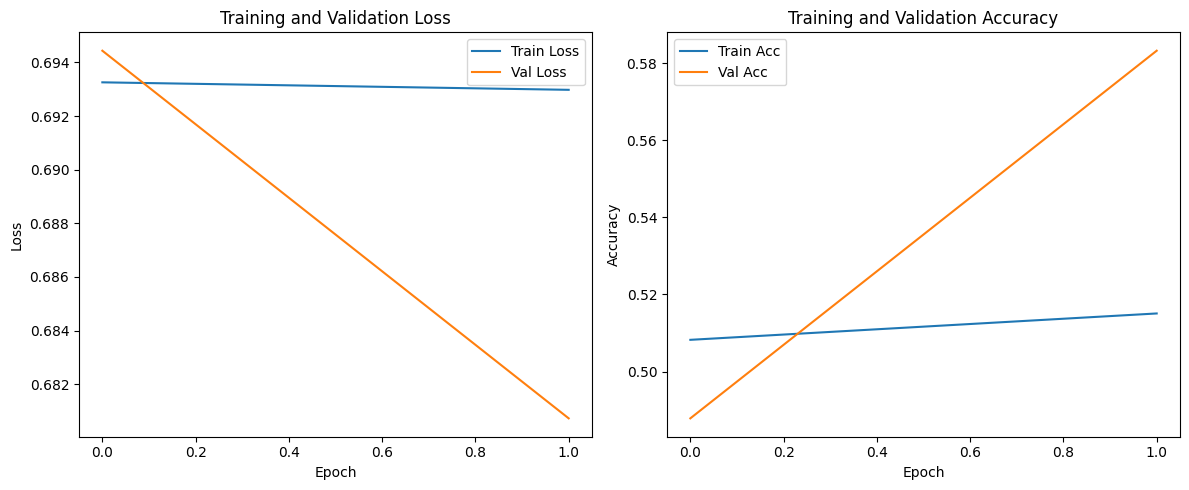

In [15]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


Evaluating: 100%|██████████| 391/391 [00:05<00:00, 77.95it/s]

Test Loss: 0.6844 | Test Acc: 56.84%


In [17]:
def predict_sentiment(model, text, vocab, max_len=200):
    """Predict sentiment for a single text input"""
    # Preprocess
    tokens = preprocess_text(text)
    # Encode
    encoded = encode_review(tokens, vocab, max_len)
    # Convert to tensor
    tensor = torch.tensor(encoded).unsqueeze(0).to(device)  # Add batch dimension

    # Set model to evaluation mode
    model.eval()

    # Get prediction
    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor).squeeze(1))

    # Return probability and sentiment
    probability = prediction.item()
    sentiment = "Positive" if probability >= 0.5 else "Negative"

    return probability, sentiment

# Test on some examples
sample_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "I was thoroughly disappointed with this film. The story made no sense and the acting was terrible.",
    "It was okay. Nothing special but not terrible either.",
    "Despite some flaws in the plot, the movie had great visual effects and good performances."
]

print("Model predictions on sample reviews:")
for review in sample_reviews:
    prob, sent = predict_sentiment(model, review, vocab)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)


Model predictions on sample reviews:
Review: This movie was absolutely amazing! The acting was ...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: I was thoroughly disappointed with this film. The ...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: It was okay. Nothing special but not terrible eith...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: Despite some flaws in the plot, the movie had grea...
Sentiment: Negative (probability: 0.4395)
--------------------------------------------------


In [18]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'model_params': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
        'n_layers': n_layers
    }
}, 'lstm_sentiment_model.pt')

print("Model saved successfully!")

Model saved successfully!


In [19]:
def create_model(n_layers):
    return SentimentLSTM(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        n_layers=n_layers
    ).to(device)

num_epochs = 5
layers_list = [1, 2, 3]

results = []

for n_layers in layers_list:
    print(f"\nTraining model with {n_layers} LSTM layer(s)...")
    model = create_model(n_layers)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_acc = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    results.append({
        'n_layers': n_layers,
        'best_val_acc': best_val_acc,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    })


Training model with 1 LSTM layer(s)...


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 154.64it/s]


Epoch 1/5: Train Loss: 0.6936, Train Acc: 0.5045 | Val Loss: 0.6939, Val Acc: 0.4891


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 160.67it/s]


Epoch 2/5: Train Loss: 0.6855, Train Acc: 0.5461 | Val Loss: 0.6838, Val Acc: 0.5910


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 88.10it/s]


Epoch 3/5: Train Loss: 0.6806, Train Acc: 0.5492 | Val Loss: 0.6942, Val Acc: 0.5352


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 149.76it/s]


Epoch 4/5: Train Loss: 0.6558, Train Acc: 0.5997 | Val Loss: 0.6910, Val Acc: 0.5855


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 155.23it/s]


Epoch 5/5: Train Loss: 0.6116, Train Acc: 0.6611 | Val Loss: 0.6919, Val Acc: 0.6000

Training model with 2 LSTM layer(s)...


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 75.38it/s]


Epoch 1/5: Train Loss: 0.6945, Train Acc: 0.5018 | Val Loss: 0.6930, Val Acc: 0.5148


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 74.76it/s]


Epoch 2/5: Train Loss: 0.6968, Train Acc: 0.5056 | Val Loss: 0.6884, Val Acc: 0.5289


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.28it/s]


Epoch 3/5: Train Loss: 0.6934, Train Acc: 0.4999 | Val Loss: 0.6926, Val Acc: 0.5398


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.58it/s]


Epoch 4/5: Train Loss: 0.6932, Train Acc: 0.5025 | Val Loss: 0.6930, Val Acc: 0.5141


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 77.13it/s]


Epoch 5/5: Train Loss: 0.6932, Train Acc: 0.5095 | Val Loss: 0.6922, Val Acc: 0.5277

Training model with 3 LSTM layer(s)...


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 50.61it/s]


Epoch 1/5: Train Loss: 0.6925, Train Acc: 0.5081 | Val Loss: 0.6879, Val Acc: 0.5332


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 51.39it/s]


Epoch 2/5: Train Loss: 0.6932, Train Acc: 0.5112 | Val Loss: 0.6934, Val Acc: 0.4871


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 51.73it/s]


Epoch 3/5: Train Loss: 0.6937, Train Acc: 0.5012 | Val Loss: 0.6937, Val Acc: 0.4871


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 51.49it/s]


Epoch 4/5: Train Loss: 0.6935, Train Acc: 0.5020 | Val Loss: 0.6945, Val Acc: 0.4871


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 51.81it/s]

Epoch 5/5: Train Loss: 0.6934, Train Acc: 0.4982 | Val Loss: 0.6940, Val Acc: 0.4871



Comparison of LSTM models with different number of layers:
   n_layers  best_val_acc  train_loss  train_acc  val_loss   val_acc
0         1      0.600000    0.611641   0.661133  0.691907  0.600000
1         2      0.539844    0.693154   0.509529  0.692230  0.527734
2         3      0.533203    0.693432   0.498234  0.694011  0.487109


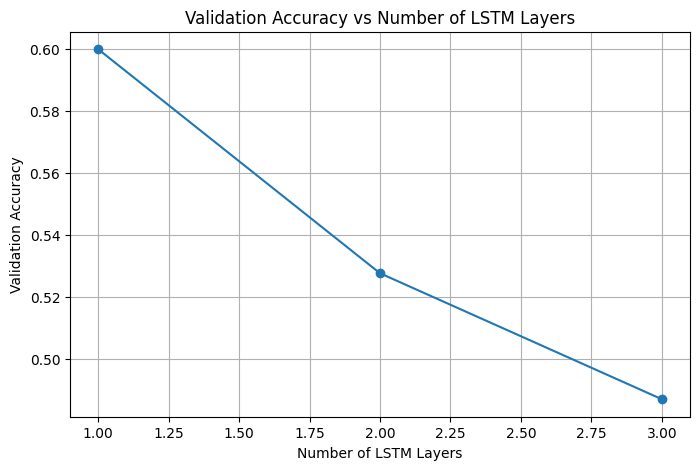

In [20]:
df_results = pd.DataFrame(results)
print("\nComparison of LSTM models with different number of layers:")
print(df_results)

plt.figure(figsize=(8, 5))
plt.plot(df_results['n_layers'], df_results['val_acc'], marker='o')
plt.title('Validation Accuracy vs Number of LSTM Layers')
plt.xlabel('Number of LSTM Layers')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()